In [ ]:
import gc
import glob
import os

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

from utils import common

In [ ]:
# Adapted from https://github.com/AI-Cloud-and-Edge-Implementations/Project15-G4/blob/master/elephantcallscounter/data_transformations/filters.py

from matplotlib import pyplot as plt
import scipy
from scipy.signal import butter


class Filters:
    @classmethod
    def butter_lowpass_filter(cls, data, cutoff, nyq, order, sampling_frequency, time, plot = False):
        """ Lowpass filter for the input signal.
        :param data:
        :type data: librosa.Audio
        :param cutoff: 
        :type cutoff: int
        :param nyq: 
        :type nyq: float
        :param order: 
        :type order: int
        :param sampling_frequency: 
        :type sampling_frequency: float
        :param time: 
        :type time: ndarray
        :param plot: defaults to False
        :type plot: bool, optional
        :return: 
        :rtype: librosa.Audio
        """
        normalized_cutoff = cutoff / nyq
        numerator_coeffs, denominator_coeffs = scipy.signal.butter(order, normalized_cutoff, btype='low', analog=False, fs=sampling_frequency)
        filtered_signal = scipy.signal.lfilter(numerator_coeffs, denominator_coeffs, data)
        if plot:
            plt.plot(time, data, 'b-', label = 'signal')
            plt.plot(time, filtered_signal, 'g-', linewidth = 2, label = 'filtered signal')
            plt.legend()
            plt.show()
        return filtered_signal


    @classmethod
    def butter_highpass_filter(cls, data, cutoff, nyq, order, sampling_frequency, time, plot = False):
        """ High pass filter for the input signal.
        :param data: 
        :type data: librosa.Audio
        :param cutoff: 
        :type cutoff: int
        :param nyq: 
        :type nyq: float
        :param order: 
        :type order: int
        :param sampling_frequency: 
        :type sampling_frequency: float
        :param time: 
        :type time: ndarray
        :param plot: defaults to False
        :type plot: bool, optional
        :return: 
        :rtype: librosa.Audio
        """
        normalized_cutoff = cutoff / nyq
        numerator_coeffs, denominator_coeffs = scipy.signal.butter(order, normalized_cutoff, btype='high', analog=False, fs=sampling_frequency)
        filtered_signal = scipy.signal.lfilter(numerator_coeffs, denominator_coeffs, data)
        if plot:
            plt.plot(time, data, 'b-', label = 'signal')
            plt.plot(time, filtered_signal, 'g-', linewidth = 2, label = 'filtered signal')
            plt.legend()
            plt.show()
        return filtered_signal

In [ ]:
def plot_audio(path, spectrogram_dir, cutoff=100,
                n_fft=2048, hop_length=512, n_mels=128, window_length=2048,
                use_linear_for_mel=False,
                extra_power=1,
                htk=False,
                display=False,
                y_max=None,
                f_max=None,
                dz=False,
                elp=False):
    basename = os.path.splitext(os.path.basename(path))[0]
    window_length = window_length or n_fft
    hop_length = hop_length or window_length//4
    input_data, sampling_frequency = librosa.load(path)
    
    # Adapted from https://github.com/AI-Cloud-and-Edge-Implementations/Project15-G4/blob/8f16003ce1e6aa0658bb71e91c7180a4729348fb/elephantcallscounter/data_analysis/analyse_sound_data.py
    duration = len(input_data) / sampling_frequency
    # plots upto sampling rate/2(Nyquist theorem)
    # Filter requirements.
    fs = sampling_frequency  # sample rate, Hz
    nyq = 0.5  # Nyquist Frequency
    order = 4  # sin wave can be approx represented as quadratic
    time = np.linspace(0, duration, len(input_data), endpoint=False)

    lowpass_signal = Filters.butter_lowpass_filter(
        input_data, cutoff, nyq, order, sampling_frequency, time, plot=False)

    cutoff_high = 10
    highpass_signal = Filters.butter_highpass_filter(
        lowpass_signal, cutoff_high, nyq, order, sampling_frequency, time, plot=False
    )
    spectrogram = librosa.feature.melspectrogram(
        y=highpass_signal, sr=fs, n_fft=n_fft,
        hop_length=hop_length, n_mels=n_mels, htk=htk,
        win_length=window_length,
        fmax=f_max
    )
    spectrogram = spectrogram ** extra_power
    if y_max is None or y_max > fs / 2:
        y_max = fs / 2
    fig, ax = plt.subplots()
    img = librosa.display.specshow(
        spectrogram, ax=ax, sr=sampling_frequency,
        hop_length=hop_length, x_axis='s', y_axis='linear' if use_linear_for_mel else 'mel',
        htk=htk, fmax=f_max
    )
    ax.set_yscale('linear')
    plt.ylim([0, y_max])
    buffer = 3
    end_buffer = duration - buffer
    if display:
        if dz:
            ax.set_title(basename)
        if elp:
            plt.axvline(x=buffer, ls='dashed')
            plt.axvline(x=end_buffer, ls='dashed')
        plt.show()
    else:
        plt.axis('off')
        plt.savefig(os.path.join(spectrogram_dir, f'{basename}.png'), transparent=True, bbox_inches='tight', pad_inches=0)
        plt.cla()
        plt.clf()
        plt.close('all')
        del img, spectrogram, input_data, lowpass_signal, highpass_signal, time
        gc.collect()

In [ ]:
BASE_ELP_DIR = 'elp_data'
BASE_DZ_DIR = 'dzanga-bai-20210816T230919Z-001/dzanga-bai'

def all_wav_to_spectrogram(wav_paths, spectrogram_dir, start=0, limit=25, **kwargs):
    wav_paths = wav_paths[start:]
    if limit is not None:
        wav_paths = wav_paths[:limit]

    # keep a track of the last successful index so we can run in batch
    # dont rerun
    for i, p in enumerate(wav_paths):
        plot_audio(p, spectrogram_dir, **kwargs)
        if limit is None or limit > 25:
            print(f'Completed: {i} {p}')


def main(elp=True, dz=False, **kwargs):
    if elp:
        wav_paths = sorted(glob.glob(os.path.join(BASE_ELP_DIR, 'short_wav_files_3', '*.wav')))
        all_wav_to_spectrogram(wav_paths,
                               os.path.join(BASE_ELP_DIR, 'fixed_spectrograms'),
                               elp=True, dz=False, **kwargs)
    if dz:
        df = common.load_dz_data(BASE_DZ_DIR)
        wav_paths = list(df['wav_path'])
        all_wav_to_spectrogram(wav_paths,
                               os.path.join(BASE_DZ_DIR, 'fixed_spectrograms'),
                               elp=False, dz=True, **kwargs)

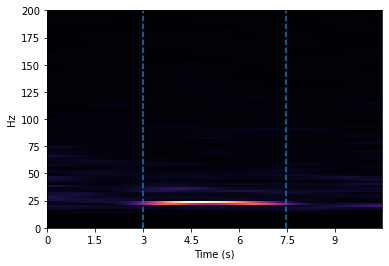

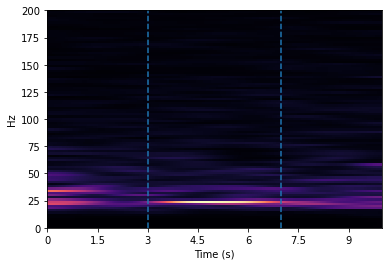

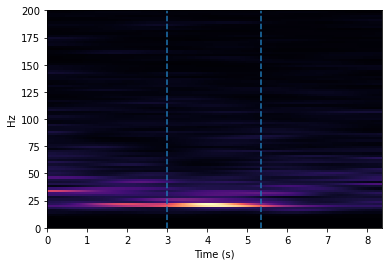

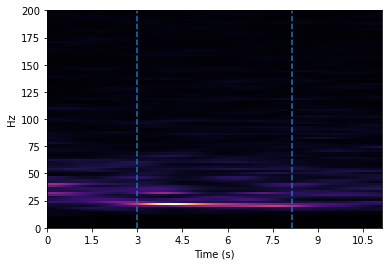

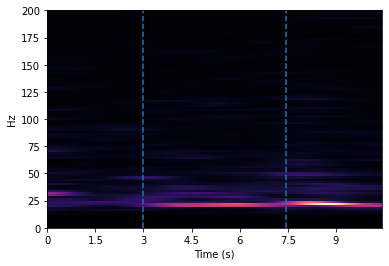

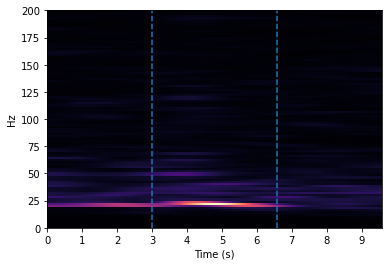

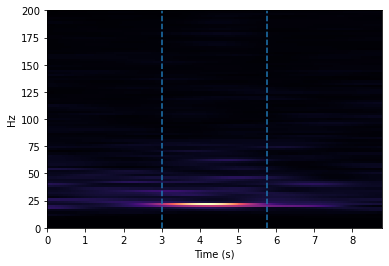

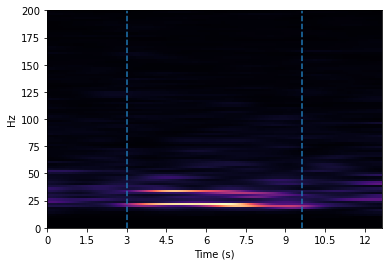

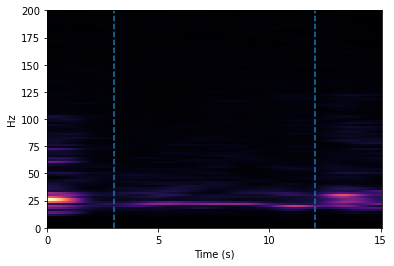

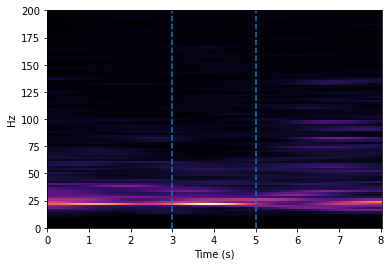

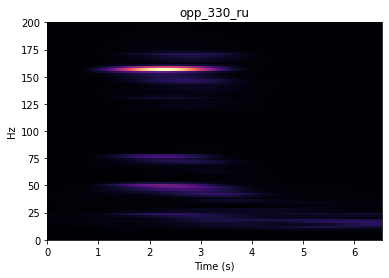

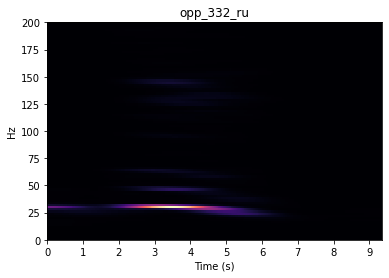

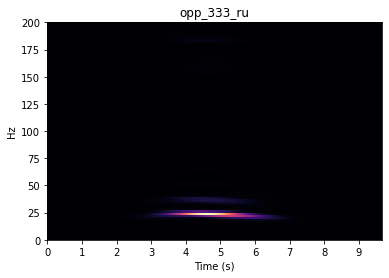

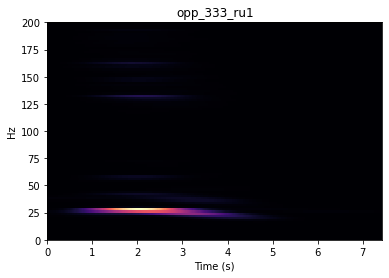

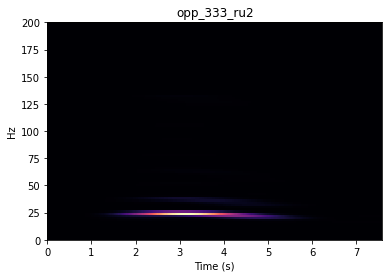

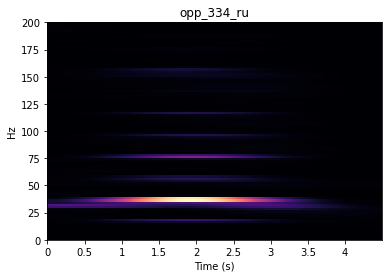

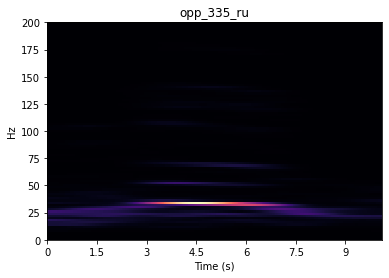

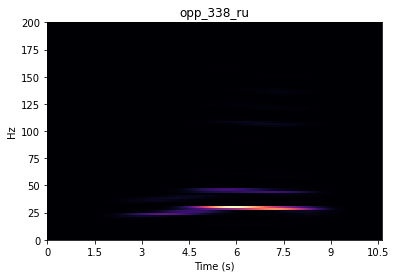

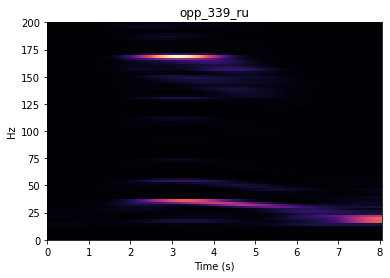

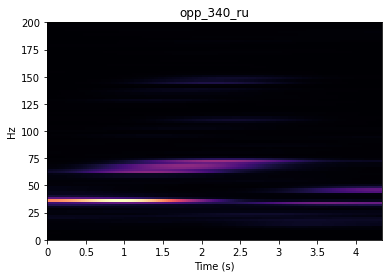

Done


In [ ]:
main(cutoff=500, 
     n_mels=250,
     n_fft=int(22050/0.98*4), 
     hop_length=int(0.0255*22050/0.98),
     window_length=None, 
     extra_power=0.9,
     y_max=200,
     f_max=500,
     htk=False,
     use_linear_for_mel=False, 
     display=True,
     start=0, 
     elp=True, 
     dz=True, 
     limit=10)   # first 10 are elp, next 10 are dz
print('Done')

In [ ]:
main(cutoff=500, 
     n_mels=250,
     n_fft=int(22050/0.98*4), 
     hop_length=int(0.0255*22050/0.98),
     window_length=None, 
     extra_power=0.9,
     y_max=200,
     f_max=500,
     htk=False,
     use_linear_for_mel=False, 
     display=False,
     start=0, 
     elp=False, 
     dz=True, 
     limit=None)
print('Done')

Completed: 0 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_330_ru.wav
Completed: 1 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_332_ru.wav
Completed: 2 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_333_ru.wav
Completed: 3 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_333_ru1.wav
Completed: 4 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_333_ru2.wav
Completed: 5 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_334_ru.wav
Completed: 6 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_335_ru.wav
Completed: 7 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_338_ru.wav
Completed: 8 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_339_ru.wav
Completed: 9 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_340_ru.wav


/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=81799
  warnings.warn(


Completed: 10 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_340_ru1.wav
Completed: 11 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_341_ru.wav
Completed: 12 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_341_ru1.wav
Completed: 13 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_341_ru2.wav
Completed: 14 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_341_ru3.wav
Completed: 15 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_343_ru.wav
Completed: 16 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_346_ru.wav
Completed: 17 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_347_ru.wav
Completed: 18 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_350_ru.wav
Completed: 19 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_350_ru1.wav
Completed: 20 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_351_ru.wav
Completed: 21 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_363_ru.wav
Completed: 22 dzanga-bai-20210816T2

/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=86408
  warnings.warn(


Completed: 26 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_381_ru.wav
Completed: 27 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_381_ru1.wav
Completed: 28 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_382_ru.wav
Completed: 29 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_386_ru.wav
Completed: 30 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_395_ru.wav
Completed: 31 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_395_ru1.wav
Completed: 32 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_401_ru1.wav


/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=72583
  warnings.warn(


Completed: 33 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_401_ru2.wav
Completed: 34 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_402_ru.wav
Completed: 35 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_402_ru1.wav
Completed: 36 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_403_ru.wav
Completed: 37 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_403_ru1.wav
Completed: 38 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_403_ru2.wav
Completed: 39 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_403_ru3.wav
Completed: 40 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_404_ru.wav
Completed: 41 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_408_ru.wav
Completed: 42 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_412_ru.wav
Completed: 43 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_413_ru.wav
Completed: 44 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_413_ru1.wav
Completed: 45 dzanga-bai-20210816T

/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=81800
  warnings.warn(


Completed: 64 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_445_ru.wav


/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=73734
  warnings.warn(


Completed: 65 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_445_ru1.wav
Completed: 66 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_449_ru.wav
Completed: 67 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_450_ru.wav
Completed: 68 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_452_ru.wav
Completed: 69 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_452_ru1.wav
Completed: 70 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_452_ru2.wav
Completed: 71 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_456_ru.wav
Completed: 72 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_457_ru.wav
Completed: 73 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_457_ru1.wav
Completed: 74 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_457_ru2.wav


/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=77191
  warnings.warn(


Completed: 75 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_466_ru.wav
Completed: 76 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_466_ru1.wav
Completed: 77 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_467_ru.wav
Completed: 78 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_467_ru1.wav
Completed: 79 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_469_ru.wav
Completed: 80 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_471_ru1.wav
Completed: 81 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_471_ru2.wav


/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=87560
  warnings.warn(


Completed: 82 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_471_ru3.wav
Completed: 83 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_473_ru.wav
Completed: 84 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_473_ru1.wav
Completed: 85 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_486_ru.wav
Completed: 86 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_491_ru.wav
Completed: 87 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_493_ru.wav
Completed: 88 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_494_ru.wav
Completed: 89 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_495_ru.wav
Completed: 90 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_498_ru1.wav


/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=89864
  warnings.warn(


Completed: 91 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_498_ru2.wav


/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=82952
  warnings.warn(


Completed: 92 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_498_ru3.wav
Completed: 93 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_499_ru.wav
Completed: 94 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_499_ru1.wav
Completed: 95 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_499_ru3.wav
Completed: 96 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_504_ru.wav
Completed: 97 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_504_ru1.wav
Completed: 98 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_504_ru2.wav
Completed: 99 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_504_ru3.wav
Completed: 100 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_504_ru4.wav
Completed: 101 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_504_ru5.wav
Completed: 102 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_505_ru.wav
Completed: 103 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_506_ru.wav
Completed: 104 dzanga-bai-20

/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=80647
  warnings.warn(


Completed: 157 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_582_ru2.wav
Completed: 158 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_582_ru3.wav
Completed: 159 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_582_ru4.wav
Completed: 160 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_582_ru5.wav
Completed: 161 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_582_ru6.wav
Completed: 162 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_584_ru.wav
Completed: 163 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_584_ru1.wav
Completed: 164 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_589_ru.wav
Completed: 165 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_595_ru.wav


/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=66822
  warnings.warn(


Completed: 166 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_598_ru.wav
Completed: 167 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_598_ru1.wav
Completed: 168 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_600_ru.wav
Completed: 169 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_601_ru1.wav
Completed: 170 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_601_ru2.wav
Completed: 171 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_602_ru.wav
Completed: 172 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_602_ru1.wav
Completed: 173 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_604_ru.wav
Completed: 174 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_606_ru.wav
Completed: 175 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_608_ru.wav
Completed: 176 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_608_ru1.wav
Completed: 177 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_608_ru2.wav
Completed: 178 dzanga-

/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=88712
  warnings.warn(


Completed: 195 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_627_ru.wav
Completed: 196 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_627_ru1.wav
Completed: 197 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_629_ru.wav
Completed: 198 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_634_ru.wav
Completed: 199 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_637_ru.wav
Completed: 200 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_639_ru.wav
Completed: 201 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_641_ru.wav
Completed: 202 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_645_ru.wav
Completed: 203 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_645_ru1.wav
Completed: 204 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_647_ru.wav
Completed: 205 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_647_ru1.wav


/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=79022
  warnings.warn(


Completed: 206 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_649_ru.wav


/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=79495
  warnings.warn(


Completed: 207 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_650_ru.wav


/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=78343
  warnings.warn(


Completed: 208 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_650_ru1.wav
Completed: 209 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_652_ru.wav
Completed: 210 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_653_ru.wav
Completed: 211 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_654_ru.wav
Completed: 212 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_655_ru.wav


/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=76039
  warnings.warn(


Completed: 213 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_661_ru.wav
Completed: 214 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_662_ru.wav
Completed: 215 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_664_ru.wav
Completed: 216 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_665_ru.wav
Completed: 217 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_667_ru.wav
Completed: 218 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_667_ru1.wav


/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=74886
  warnings.warn(


Completed: 219 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_667_ru2.wav
Completed: 220 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_668_ru.wav
Completed: 221 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_669_ru.wav
Completed: 222 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_669_ru1.wav
Completed: 223 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_674_ru.wav
Completed: 224 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_688_ru.wav
Completed: 225 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_688_ru1.wav
Completed: 226 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_692_ru.wav
Completed: 227 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_694_ru.wav
Completed: 228 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_697_ru.wav
Completed: 229 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_698_ru.wav
Completed: 230 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_699_ru.wav
Completed: 231 dzanga-bai

/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=39172
  warnings.warn(


Completed: 258 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_755_ru.wav


/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=63366
  warnings.warn(


Completed: 259 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_755_ru1.wav


/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=52997
  warnings.warn(


Completed: 260 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_755_ru2.wav
Completed: 261 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_758_ru1.wav
Completed: 262 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_758_ru2.wav
Completed: 263 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_758_ru3.wav
Completed: 264 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_758_ru3a.wav
Completed: 265 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_758_ru4.wav
Completed: 266 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_759_ru.wav
Completed: 267 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_759_ru1.wav
Completed: 268 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_762_ru.wav
Completed: 269 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_763_ru.wav
Completed: 270 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_763_ru1.wav
Completed: 271 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_763_ru2.wav
Completed: 272 dza

/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=64195
  warnings.warn(


Completed: 286 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_793_ru.wav
Completed: 287 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_800_ru.wav
Completed: 288 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_801_ru.wav
Completed: 289 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_804_ru.wav
Completed: 290 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_806_ru.wav
Completed: 291 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_807_ru.wav
Completed: 292 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_807_ru1.wav
Completed: 293 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_807_ru2.wav
Completed: 294 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_809_ru.wav
Completed: 295 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_809_ru1.wav
Completed: 296 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_810_ru.wav
Completed: 297 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_811_ru.wav
Completed: 298 dzanga-bai

/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=76578
  warnings.warn(


Completed: 310 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_830_ru1.wav
Completed: 311 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_830_ru2.wav


/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=83910
  warnings.warn(


Completed: 312 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_830_ru3.wav


/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=87169
  warnings.warn(


Completed: 313 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_830_ru4.wav
Completed: 314 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_831_ru1.wav
Completed: 315 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_831_ru2.wav
Completed: 316 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_832_ru1.wav
Completed: 317 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_832_ru2.wav
Completed: 318 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_833_ru1.wav
Completed: 319 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_833_ru2.wav
Completed: 320 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_835_ru.wav
Completed: 321 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_836_ru.wav
Completed: 322 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_837_ru.wav
Completed: 323 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_838_ru.wav
Completed: 324 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_843_ru.wav
Completed: 325 dzanga

/home/home/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=90000 is too small for input signal of length=77800
  warnings.warn(


Completed: 335 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_859_ru.wav
Completed: 336 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_864_ru1.wav
Completed: 337 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_865_ru1.wav
Completed: 338 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_866_ru.wav
Completed: 339 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_868_ru.wav
Completed: 340 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_870_ru1.wav
Completed: 341 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_870_ru2.wav
Completed: 342 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_872_ru1.wav
Completed: 343 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_872_ru2.wav
Completed: 344 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_872_ru3.wav
Completed: 345 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_872_ru4.wav
Completed: 346 dzanga-bai-20210816T230919Z-001/dzanga-bai/raw_wav/opp_873_ru2.wav
Completed: 347 dzan